In [1]:
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import json
import os
import rasterio
import numpy as np


## cut raster

In [2]:
gdf = gpd.read_file('../../konverto_data_package/polygons/polygons.geojson')

In [3]:
gdf

,type,geometry
0,winery,MULTIPOLYGON EMPTY
1,winery,"MULTIPOLYGON (((675007.413 5143326.011, 675067..."
2,winery,"MULTIPOLYGON (((675066.550 5143267.678, 675149..."
3,winery,"MULTIPOLYGON (((674760.935 5143198.037, 674834..."
4,winery,"MULTIPOLYGON (((673672.158 5143505.380, 673678..."
...,...,...
96,apple orchard,"MULTIPOLYGON (((673977.481 5136172.898, 674005..."
97,winery,"MULTIPOLYGON (((673322.831 5136427.445, 673328..."
98,winery,"MULTIPOLYGON (((672685.775 5139609.934, 672709..."
99,apple orchard,"MULTIPOLYGON (((678006.627 5145427.665, 677996..."


In [4]:
gdf1 = gdf.loc[11]
gdf1

type                                                   winery
geometry    MULTIPOLYGON (((673161.0209203674 5138097.8153...
Name: 11, dtype: object

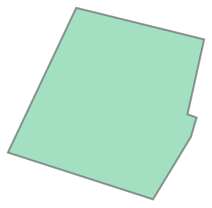

In [5]:
gdf.loc[8].geometry
    

In [6]:
raster = rasterio.open('../../konverto_data_package/climate/tmean/tmean_2020_01_21.tif')
raster

<open DatasetReader name='../../konverto_data_package/climate/tmean/tmean_2020_01_21.tif' mode='r'>

In [7]:
out, inside  = mask(raster, gdf1[['geometry']], crop=True, invert=False, all_touched=True, nodata=np.nan)
out

array([[[       nan, 0.9553406 ],
        [0.88942724, 0.7424053 ],
        [0.8325057 , 0.34043524]]], dtype=float32)

In [8]:
def get_dataset_file_paths():

    directory = "../../konverto_data_package"
    
    datasets = {}
    for root, dirs, files in os.walk(directory):
        # print(f"Current directory: {root}")
        if "visual" in root:
            continue

        tif_files = [f for f in files if f.endswith(".tif") and not f.startswith(".")]
        tif_paths = [os.path.join(root, f) for f in tif_files]


        if len(tif_files) > 0:

            if "climate" in tif_paths[0]:
                dates = ["-".join(f.replace(".tif", "").split("_")[1:]) for f in tif_files]
            elif "satellite" in tif_paths[0]:
                datestrings = [f.replace(".tif", "").split("_")[0] for f in tif_files]
                dates = [d[:4] + "-" + d[4:6] + "-" + d[6:] for d in datestrings]
            else:
                dates = None
            

            if dates:
                dataset_name = os.path.basename(root)
                
                for date, fp in zip(dates, tif_paths):
                    if date in datasets:
                        datasets[date].update({dataset_name: fp})
                    else:
                        datasets[date] = {dataset_name: fp}
            
            if "terrain" in tif_paths[0]:
                dataset_names = [n.replace(".tif", "") for n in tif_files]
                for date in datasets.keys():
                    for dn, fp in zip(dataset_names, tif_paths):
                        datasets[date].update({dn: fp})

                    


    return datasets

In [9]:
datasets = get_dataset_file_paths()

In [10]:
datasets["2020-03-22"]

{'gdd': '../../konverto_data_package\\climate\\gdd\\gdd_2020_03_22.tif',
 'pmm': '../../konverto_data_package\\climate\\pmm\\pmm_2020_03_22.tif',
 'tmax': '../../konverto_data_package\\climate\\tmax\\tmax_2020_03_22.tif',
 'tmean': '../../konverto_data_package\\climate\\tmean\\tmean_2020_03_22.tif',
 'tmin': '../../konverto_data_package\\climate\\tmin\\tmin_2020_03_22.tif',
 'ndvi': '../../konverto_data_package\\satellite\\indices\\ndvi\\20200322_ndvi.tif',
 'ndwi': '../../konverto_data_package\\satellite\\indices\\ndwi\\20200322_ndwi.tif',
 'reci': '../../konverto_data_package\\satellite\\indices\\reci\\20200322_reci.tif',
 'elevation': '../../konverto_data_package\\terrain\\elevation.tif',
 'exposure': '../../konverto_data_package\\terrain\\exposure.tif',
 'slope': '../../konverto_data_package\\terrain\\slope.tif'}

In [11]:
def extract_raster_data_from_polygon(polygon, paths_data, stat = "mean"):

    data = {}
    mean = {}
    std = {}
    for dataset_name, fpath in paths_data.items():
        raster = rasterio.open(fpath)
        if stat == "mean":
            data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        elif stat == "std":
            data[dataset_name] = np.nanstd(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        elif stat == "max":
            data[dataset_name] = np.nanmax(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        elif stat == "min":
            data[dataset_name] = np.nanmin(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        elif stat == "mean_std":
            mean[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
            std[dataset_name] = np.nanstd(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
            data = (mean, std)



    return data


def get_time_series_data_from_polygon(polygon, stat="mean"):
    
    paths_dataset = get_dataset_file_paths()
    dti = pd.date_range("2020-03-22", end="2022-12-31", freq="12D")
    rows = []
    for d in dti:
        try:
            date_string = d.strftime("%Y-%m-%d")
            row = extract_raster_data_from_polygon(polygon, paths_dataset[date_string], stat)
        except:
            print(d)
        rows.append(row)
    ts = pd.DataFrame(index=dti,data=rows)

    return ts
    


In [12]:
ts = get_time_series_data_from_polygon(gdf.loc[8][['geometry']])

C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])


2020-11-05 00:00:00


C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[datase

2021-07-03 00:00:00


C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[datase

2022-06-16 00:00:00
2022-06-28 00:00:00


C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[dataset_name] = np.nanmean(mask(raster, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
C:\Users\rabjo\AppData\Local\Temp\ipykernel_31168\2978814946.py:9: RuntimeWarning: Mean of empty slice
  data[datase

In [13]:
ts.head()

,gdd,pmm,tmax,tmean,tmin,ndvi,ndwi,reci,elevation,exposure,slope
2020-03-22,3.051428,0.524082,18.794580,12.797966,7.310073,0.200307,-0.062845,0.502375,234.689514,117.242249,13.417278
2020-04-03,0.418571,0.000000,19.729502,10.133245,1.106295,NaN,NaN,NaN,234.689514,117.242249,13.417278
2020-04-15,2.890000,0.000000,21.229456,12.031464,4.547482,NaN,NaN,NaN,234.689514,117.242249,13.417278
2020-04-27,7.941429,0.000158,22.510900,17.254629,13.374471,NaN,NaN,NaN,234.689514,117.242249,13.417278
2020-05-09,9.821428,0.000000,27.441988,19.986624,12.198226,NaN,NaN,NaN,234.689514,117.242249,13.417278


In [6]:
# ts.to_csv('fiel8_4Year_time_series.csv')

In [ ]:
data_ = gpd.read_file('../complete.geojson')
print(data_.name.unique())
print(len(data_))
import warnings
from tqdm import tqdm
pbar = tqdm(total=len(data_))
warnings.filterwarnings('ignore')
for index, row in data_.iterrows():
    df = get_time_series_data_from_polygon(data_.loc[index][['geometry']])
    df.to_csv("../csv_dump/{}.csv".format(data_.loc[index, "name"]))
    pbar.update(1)